# Multi Touch Attribution Models Using Markov Chain

## Multi Touch Attribution Models

Advertising campaigns are often launched across multiple channels. Traditional advertising channels include outdoor billboard, TV, radio, newspapers and magazines, and direct mailing. Digital advertising channels include search, online display, social, video, mobile and email. Regarding the digital advertising channels, typically, multiple advertising channels have delivered advertisement impressions to a user. When the user then makes a purchase decision or signs up to a service being advertised, the advertiser wants to determine which ads have contributed to the user’s decision. This step is critical in completing the feedback loop so that one can analyze, report and optimize an advertising campaign. This problem of interpreting the influence of advertisements to the user’s decision process is called the attribution problem. The goal of attribute modeling is to pin-point the credit assignment of each positive user to one or more advertising touch point, which is illustrated in Figure 1. (Shao et al., 2011)

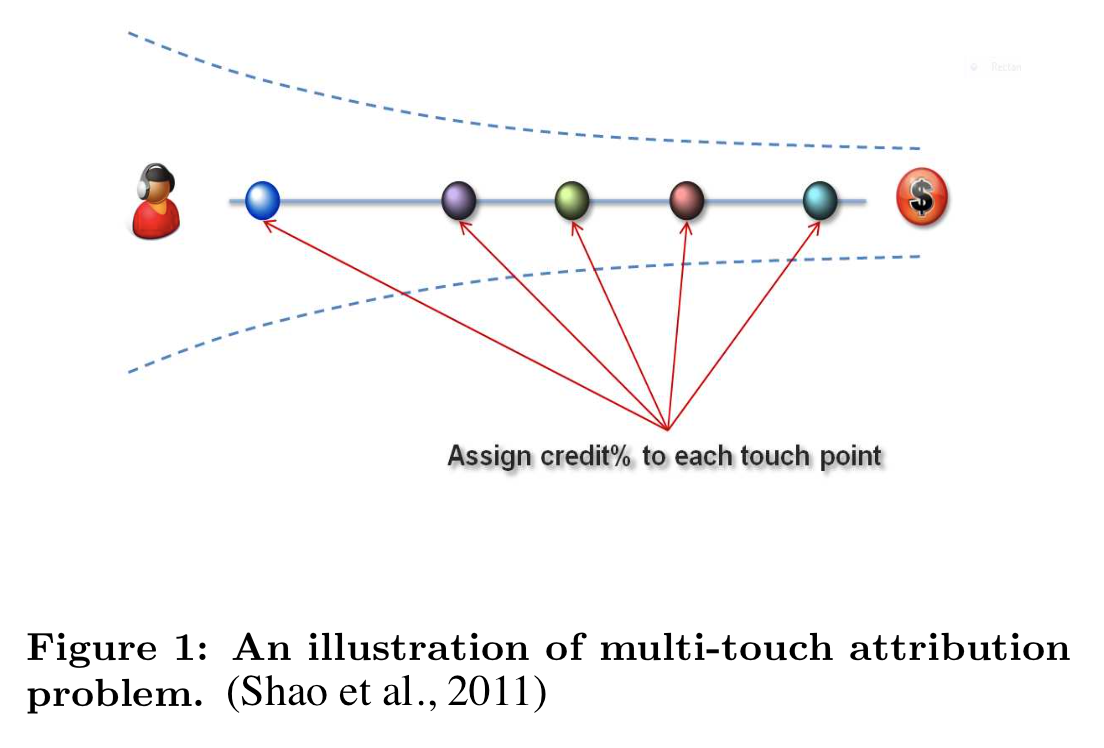

## Problem Settings

- Given: touch points from multiple channels
- Goal: predict binary outcome; positive meaning a user is to make a purchase action and negative meaning otherwise

This is a typical classification problem

## Data

We used the data from Kaggle (https://www.kaggle.com/kishlaya18/customer-purchase-journey-netherlands#TravelData.csv). TravelData.csv is the major file containing information about the customer purchase journey across different online platforms.

## Data Attribute

1. UserID: unique user ID one user may have multiple purchases, so can be connected with more than one PurchaseID
2. PurchaseID: unique purchase ID	unique ID to identify which touchpoint is related to a certain purchase journey
3. TIMESPSS: time stamp including year, month, day, hour, minute and second
4. Duration: seconds spend on a touchpoint (capped at 720 seconds). this information is not available for Company initiated touchpoints
5. DEVICE_TYPE: Indicates whether the touchpoint was reached with a smartphone/tablet (MOBILE) or desktop/laptop (FIXED)
6. type_touch: type of touchpoint (see below)
7. purchase_own: indicates whether a certain purchase journey is related to a booking with the travel agency
8. purchase_any: indicates whether a certain purchase journey is related to a booking with the travel agency or a competitor
9. MobilePanel: months the UserID was part of the mobile panel (max = 17 = all months). this number is user related rather than touchpoint related (similar to demographics)
10. FixedPanel: months the UserID was part of the fixed panel (max = 17 = all months). this number is user related rather than touchpoint related (similar to demographics)

You can download the data via [this link](httpshttps://drive.google.com/file/d/1TLq6txFNfONwjA4ObETsm0vl6q5vY2tm/view?usp=sharing).

### Description regarding 6. type_touch

- 1. Accomodations Website; Consumer initiated touchpoint
- 2. Accomodations App; Consumer initiated touchpoint
- 3. Accomodations Search; Consumer initiated touchpoint
- 4. Information / comparison Website; Consumer initiated touchpoint
- 5. Information / comparison App; Consumer initiated touchpoint
- 6. Information / comparison Search; Consumer initiated touchpoint
- 7. Touroperator / Travel agent Website Competitor; Consumer initiated touchpoint
- 8. Touroperator / Travel agent App Competitor; Consumer initiated touchpoint
- 9. Touroperator / Travel agent Search Competitor; Consumer initiated touchpoint
- 10. Touroperator / Travel agent Website Focus brand; Consumer initiated touchpoint
- 12. Touroperator / Travel agent Search Focus brand; Consumer initiated touchpoint
- 13. Flight tickets Website; Consumer initiated touchpoint
- 14. Flight tickets App; Consumer initiated touchpoint
- 15. Flight tickets Search; Consumer initiated touchpoint
- 16. generic search; Consumer initiated touchpoint
- 18. AFFILIATES; Company intiated touchpoint (Focus brand)
- 19. BANNER; Company intiated touchpoint (Focus brand)
- 20. EMAIL; Company intiated touchpoint (Focus brand)
- 21. PREROLLS; Company intiated touchpoint (Focus brand)
- 22. RETARGETING; Company intiated touchpoint (Focus brand)

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

In [24]:
# Read Wholesale customers data
df = pd.read_csv('TravelData.csv')

# Show dataframe
df.head()

,UserID,PurchaseID,TIMESPSS,Duration,DEVICE_TYPE,type_touch,purchase_own,purchase_any,MobilePanel,FixedPanel
0,9558,1,2016-03-12 22:18:34,5.786,MOBILE,7,0,0,0,0
1,9558,1,2016-03-13 05:25:49,65.725,MOBILE,7,0,0,0,0
2,9558,1,2016-03-13 12:26:21,6.492,MOBILE,7,0,0,0,0
3,9657,2,2015-07-18 13:00:38,57.000,FIXED,4,0,0,0,0
4,1,3,2015-08-07 19:16:59,120.000,FIXED,7,0,0,0,17


In [25]:
touch_dict = {1: "Accomodations Website",
              2: "Accomodations App",
              3: "Accomodations Search",
              4: "Comparison Website",
              5: "Comparison App",
              6: "Comparison Search",
              7: "Travel agent Website Competitor",
              8: "Travel agent App Competitor",
              9: "Travel agent Search Competitor",
              10: "Travel agent Website Focus brand",
              12: "Travel agent Search Focus brand",
              13: "Flight tickets Website",
              14: "Flight tickets App",
              15: "Flight tickets Search",
              16: "generic search",
              18: "AFFILIATES",
              19: "BANNER",
              20: "EMAIL",
              21: "PREROLLS",
              22: "RETARGETING"
             }

touch_df = pd.DataFrame(list(touch_dict.items()), columns=['type_touch','touch_name'])
df = pd.merge(df, touch_df, how='left', on='type_touch')

## Preprocessing of data

At this moment, we want to know the customer journey path to apply Markov chain model. 

## Prepare for X: features / independent variables
We first obtain information the order which touchpoint was accessed per purchase ID.

In [26]:
from collections import defaultdict

df = df.sort_values(['PurchaseID', 'TIMESPSS'], ascending=[False, True])
df['visit_order'] = df.groupby('PurchaseID').cumcount() + 1
df.head()

,UserID,PurchaseID,TIMESPSS,Duration,DEVICE_TYPE,type_touch,purchase_own,purchase_any,MobilePanel,FixedPanel,touch_name,visit_order
2456408,7279,29012,2015-08-21 22:00:55,48.0,FIXED,13,0,0,0,4,Flight tickets Website,1
2456409,7279,29012,2015-08-21 22:01:43,3.0,FIXED,13,0,0,0,4,Flight tickets Website,2
2456410,7279,29012,2015-09-10 13:01:19,29.0,FIXED,13,0,0,0,4,Flight tickets Website,3
2456411,7279,29012,2015-09-10 13:01:49,120.0,FIXED,13,0,0,0,4,Flight tickets Website,4
2456412,7279,29012,2015-09-15 09:20:33,179.0,FIXED,13,0,0,0,4,Flight tickets Website,5


Then, we get customer journey path per purchase ID.

In [28]:
df_paths = df.groupby('PurchaseID')['touch_name'].aggregate(lambda x: x.unique().tolist()).reset_index()
df_last_interaction = df.drop_duplicates('PurchaseID', keep='last')[['PurchaseID', 'purchase_any']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='PurchaseID')
df_paths['path'] = np.where(
    df_paths['purchase_any'] == 0,
    ['Start'] + df_paths['touch_name'] + ['Null'],
    ['Start'] + df_paths['touch_name'] + ['Purchased'])

df_paths = df_paths[['PurchaseID', 'path']]

TypeError: ignored

In [ ]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Purchased') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

KeyError: ignored

## Calculate transition matrix

First, we count all the different state transition

In [ ]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Purchased', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

NameError: ignored

Then, calculate transition probabilities

In [ ]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Purchased', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

Finally, we get transition matrix

In [ ]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Purchased', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [ ]:
trans_matrix

,Travel agent Website Competitor,Purchased,Comparison Search,Accomodations Website,generic search,Accomodations App,PREROLLS,Travel agent Search Competitor,RETARGETING,Flight tickets Search,...,Start,Travel agent Search Focus brand,Comparison Website,Flight tickets Website,Null,Comparison App,Flight tickets App,BANNER,Travel agent App Competitor,Travel agent Website Focus brand
Travel agent Website Competitor,0.000000,0.035554,0.004481,0.213500,0.077335,0.003200,0.005644,0.012685,0.003608,0.014373,...,0.0,0.001629,0.114344,0.087984,0.355426,0.003608,0.001455,0.002968,0.001280,0.037707
Purchased,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Comparison Search,0.031674,0.102564,0.000000,0.043741,0.054299,0.006033,0.004525,0.045249,0.009050,0.045249,...,0.0,0.012066,0.294118,0.045249,0.193062,0.013575,0.006033,0.001508,0.003017,0.024133
Accomodations Website,0.197474,0.043900,0.003341,0.000000,0.077152,0.006525,0.005899,0.007673,0.002819,0.012528,...,0.0,0.001253,0.122827,0.079971,0.373284,0.004541,0.001931,0.003497,0.000626,0.022290
generic search,0.136312,0.047474,0.011455,0.168385,0.000000,0.005218,0.004455,0.021128,0.003182,0.029273,...,0.0,0.003946,0.120020,0.057783,0.299733,0.005727,0.002927,0.002291,0.001145,0.028382
Accomodations App,0.077139,0.068724,0.007013,0.113604,0.065919,0.000000,0.000000,0.014025,0.001403,0.025245,...,0.0,0.000000,0.072931,0.053296,0.328191,0.060309,0.035063,0.000000,0.014025,0.026648
PREROLLS,0.084063,0.040280,0.001751,0.110333,0.056042,0.001751,0.000000,0.008757,0.012259,0.015762,...,0.0,0.000000,0.110333,0.056042,0.271454,0.005254,0.003503,0.140105,0.000000,0.036778
Travel agent Search Competitor,0.161069,0.071756,0.032061,0.072519,0.093130,0.006107,0.001527,0.000000,0.010687,0.041221,...,0.0,0.019084,0.071756,0.056489,0.247328,0.005344,0.004580,0.000763,0.004580,0.042748
RETARGETING,0.115473,0.100462,0.012702,0.093533,0.056582,0.003464,0.004619,0.020785,0.000000,0.018476,...,0.0,0.010393,0.099307,0.068129,0.263279,0.008083,0.001155,0.004619,0.001155,0.054273
Flight tickets Search,0.071317,0.062988,0.018740,0.080687,0.086413,0.005206,0.002603,0.034878,0.004685,0.000000,...,0.0,0.003644,0.080687,0.179594,0.276939,0.009370,0.007808,0.002603,0.003123,0.023425


## Plotting transition matrix

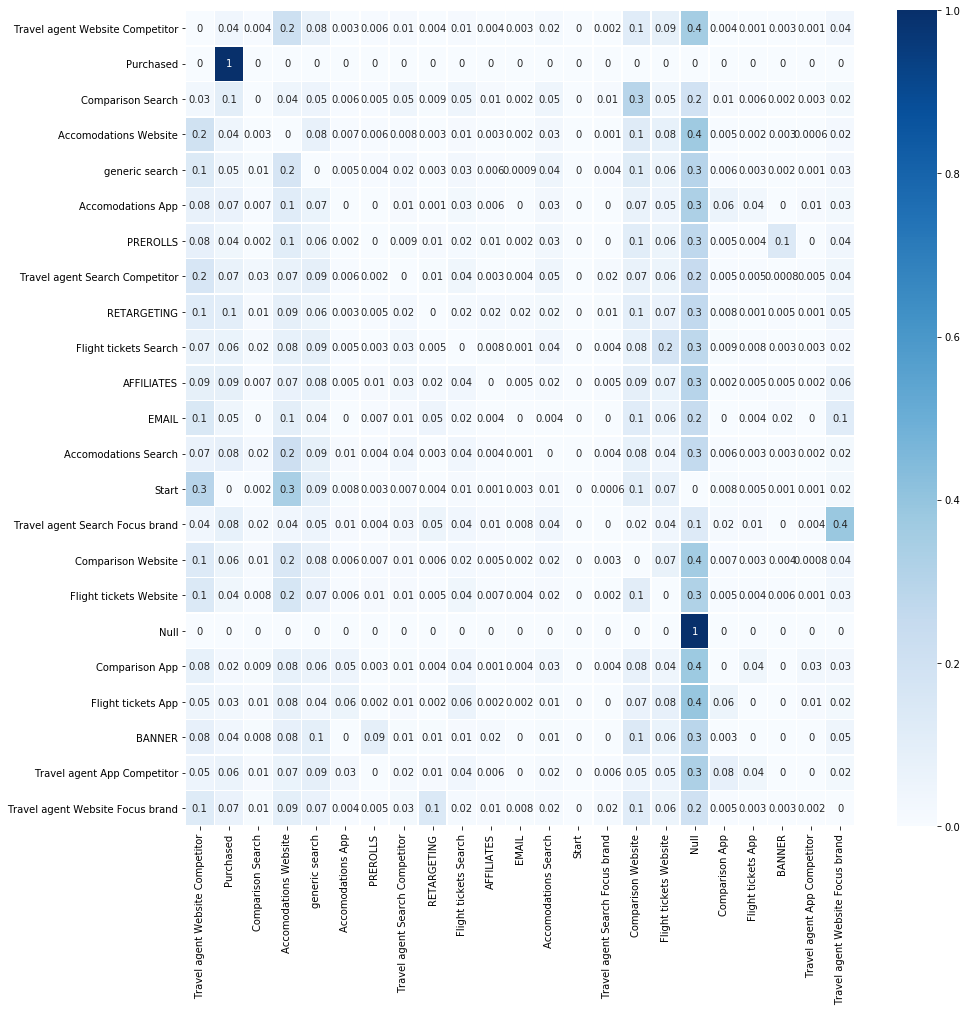

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(trans_matrix, annot=True, cmap='Blues', fmt='.1g', linewidths=.5)
plt.show()

Now, we can assess the impact it would have on overall conversion if we were to remove a touchpoint from our state-space.

In [ ]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    touch_names = [touch_name for touch_name in df.columns if touch_name not in ['Start', 'Null', 'Purchased']]
    
    for touch_name in touch_names:
        removal_df = df.drop(touch_name, axis=1).drop(touch_name, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Purchased']].drop(['Null', 'Purchased'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Purchased'], axis=1).drop(['Null', 'Purchased'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[touch_name] = removal_effect

    return removal_effects_dict

removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [ ]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

## Plotting attributions

the total number of conversion attributed to each touchpoint by the Markov Chain algorithm

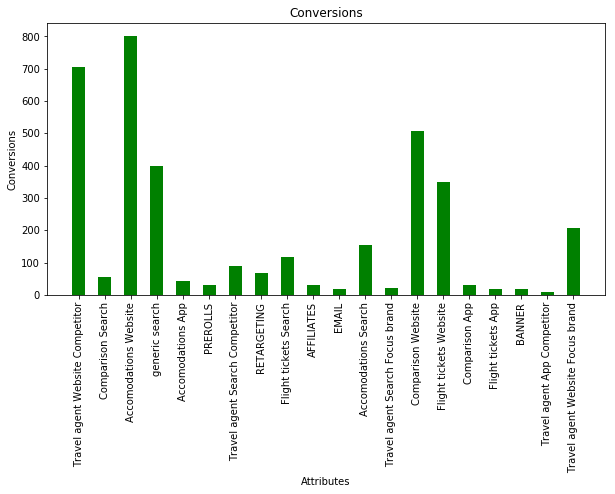

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(attributions.keys(), attributions.values(), width=.5, color='g')
plt.xlabel('Attributes')
plt.ylabel('Conversions')
plt.xticks(rotation=90)
plt.title('Conversions')
plt.show()

## Reference

C,Bishop. (2006), Pattern Recognition and Machine Learning, Springer.

https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323